In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

df = pd.read_csv('weatherHistory.csv')
sequence = df.Summary.tolist()
d = dict(sorted(Counter(sequence).items(), key=lambda x: x[1], reverse=True))
d

{'Partly Cloudy': 31733,
 'Mostly Cloudy': 28094,
 'Overcast': 16597,
 'Clear': 10890,
 'Foggy': 7148,
 'Breezy and Overcast': 528,
 'Breezy and Mostly Cloudy': 516,
 'Breezy and Partly Cloudy': 386,
 'Dry and Partly Cloudy': 86,
 'Windy and Partly Cloudy': 67,
 'Light Rain': 63,
 'Breezy': 54,
 'Windy and Overcast': 45,
 'Humid and Mostly Cloudy': 40,
 'Drizzle': 39,
 'Breezy and Foggy': 35,
 'Windy and Mostly Cloudy': 35,
 'Dry': 34,
 'Humid and Partly Cloudy': 17,
 'Dry and Mostly Cloudy': 14,
 'Rain': 10,
 'Windy': 8,
 'Humid and Overcast': 7,
 'Windy and Foggy': 4,
 'Dangerously Windy and Partly Cloudy': 1,
 'Windy and Dry': 1,
 'Breezy and Dry': 1}

In [49]:
class SlidingDataset(Dataset):
    def __init__(self,
                 sequence = sequence,
                 block_size: int = 1):

        assert block_size > 0
        sequence = [list(d.keys()).index(i) for i in sequence]
        sequence = torch.tensor(sequence)
        self.sequence = sequence
        self.block_size = block_size
    
    def __len__(self):
        return len(self.sequence) - self.block_size
    
    def __getitem__(self, idx):
        return self.sequence[idx:idx+self.block_size], self.sequence[idx+1:idx+self.block_size+1]

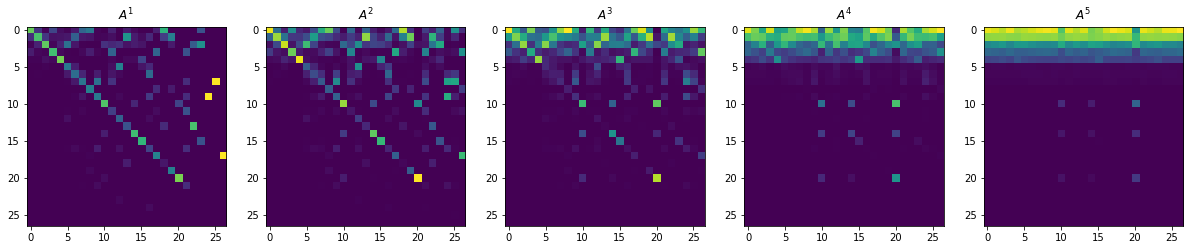

In [50]:
l = len(d)
A = torch.zeros(l,l)

for i, j in zip(SlidingDataset().sequence[:-1], SlidingDataset().sequence[1:]):
    A[j.item(),i.item()] += 1

A /= A.sum(dim=0)

plt.figure(figsize=(25, 5))
for i in range(1,6):
    _A = A.clone()
    for _ in range(i-1):
        _A @= _A
    plt.subplot(1,6,i)
    plt.title(rf'$A^{i}$')
    plt.imshow(_A)
plt.show()

100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


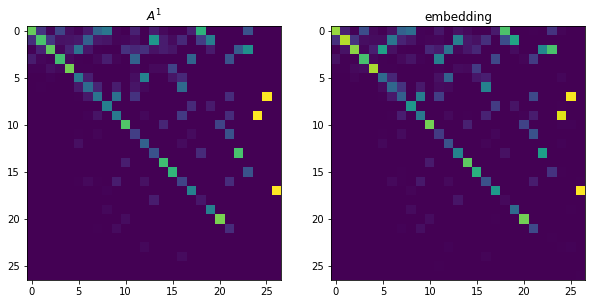

In [51]:
embedding = nn.Embedding(l, l)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(embedding.parameters(), lr=.1)
from tqdm import tqdm

epoch = 5
for e in tqdm(range(epoch)):
    for x, y in DataLoader(SlidingDataset(block_size=1), batch_size=512):
        optimizer.zero_grad()

        x = x.flatten(0)
        y = y.flatten(0)
        y_hat = embedding(x)
        loss = criterion(y_hat, y)

        loss.backward()
        optimizer.step()

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.title(r'$A^1$')
plt.imshow(A)
plt.subplot(1,2,2)
plt.title('embedding')
plt.imshow(embedding.weight.softmax(1).T.detach().numpy())
plt.show()

In [52]:
embedding = nn.Embedding(l, 2)
linear = nn.Linear(2, l, bias=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(embedding.parameters(), lr=.1)

epoch = 20
for e in tqdm(range(epoch)):
    for x, y in DataLoader(SlidingDataset(block_size=1), batch_size=512):
        optimizer.zero_grad()

        x = x.flatten(0)
        y = y.flatten(0)
        z = embedding(x)
        y_hat = linear(z)
        loss = criterion(y_hat, y)

        loss.backward()
        optimizer.step()

100%|██████████| 20/20 [00:06<00:00,  2.92it/s]


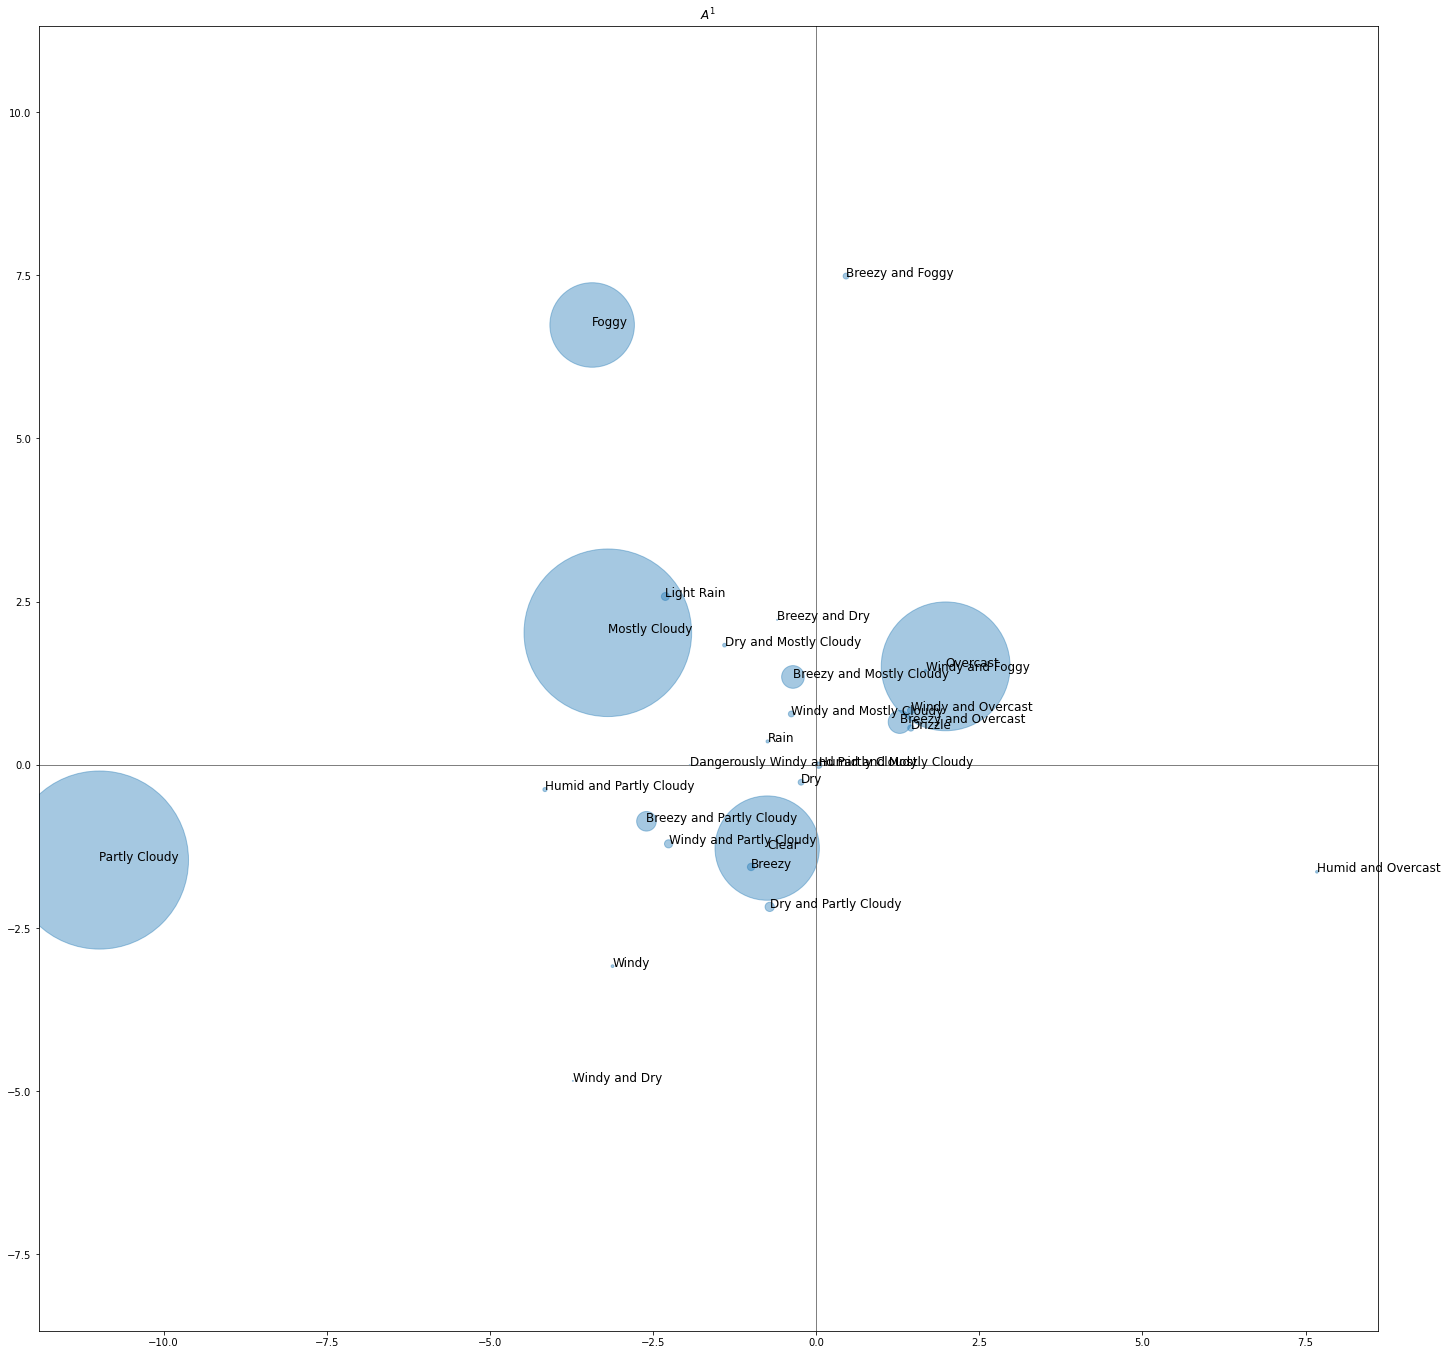

In [53]:
z = embedding(torch.arange(0, l)).detach().cpu()

plt.figure(figsize=(24,24))
plt.title(r'$A^1$')
plt.scatter(*z.T, s=torch.tensor(list(d.values())), alpha=.4)
plt.axis('equal')
plt.axvline(0, lw=1, c='grey')
plt.axhline(0, lw=1, c='grey')
for i in range(l):
    plt.text(*z[i], s=list(d.keys())[i], fontsize=12)
plt.show()